In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("..")

In [3]:
from pyro import distributions as dist

In [4]:
from model import YModel, OptLoss
from gan import Generator, Discriminator, WSDiscriminator, GANLosses
from metrics import Metrics
from utils import sample_noise, iterate_minibatches, generate_data

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)


from collections import defaultdict
%matplotlib inline

In [5]:
from comet_ml import API
import comet_ml

comet_api = API()
comet_api.get()

['shir994']

In [7]:
def extract_metrics(exp, hyper_params, metrics, mask):
    for metric in exp.data['metrics']:
        metric_values = np.array(list(zip(*exp.metrics_raw[metric]))[1])
        metrics[metric].append([metric_values[mask], hyper_params['data_size']])

In [8]:
#mask = list(np.arange(0, 20)) + [50] + [100]
mask = list(np.arange(500))

In [10]:

metrics = defaultdict(list)
for experiment in comet_api.get("shir994/sigmoid-optim/"):
    
    hyper_params = {}
    for param in experiment.parameters:
        hyper_params[param["name"]] = param["valueMin"]
    
    extract_metrics(experiment, hyper_params, metrics, mask)

In [190]:
# plt.figure(figsize=(12,6))
# plt.pcolormesh(range(0,30), sizes, data, cmap=my_cmap);
# plt.colorbar()
# plt.yscale("log")

In [18]:
# metrics = list(zip(*exp.metrics_raw["train_average_mu_JS"]))
# plt.plot(*metrics);

# Check model

In [6]:
exp = comet_api.get("shir994/2d-mu/f6432030afa64685b5df9497ec03bd9b")
hyper_params = {}
for param in exp.parameters:
    hyper_params[param["name"]] = param["valueMin"]

In [7]:
TASK = int(hyper_params['TASK'])
NOISE_DIM = int(hyper_params["NOISE_DIM"])

In [8]:
generator = Generator(NOISE_DIM, out_dim = 1, input_param=3).to(device)
if TASK == 4:
    discriminator = WSDiscriminator(in_dim=1).to(device)
else:
    discriminator = Discriminator(in_dim=1, input_param=3).to(device)

y_sampler = YModel()
fixed_noise = torch.Tensor(sample_noise(10000, NOISE_DIM)).to(device)
metric_calc = Metrics((-50, 50), 100)

In [9]:
import io

asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == "2d_mu_mu_2d.tar"][0]
params = exp.get_asset(asset_id)
state_dict = torch.load(io.BytesIO(params))

In [10]:
state_dict.keys()

dict_keys(['gen_state_dict', 'dis_state_dict', 'genopt_state_dict', 'disopt_state_dict', 'epoch'])

In [139]:
generator.load_state_dict(state_dict['gen_state_dict'])

In [180]:
#mu = dist.Uniform(-10,10).sample([10000, 2])
mu = torch.tensor([0.,0.]).reshape(1, -1).repeat(10000, 1)
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))

y_sampler.make_condition_sample({'mu': mu, 'X': x_r})

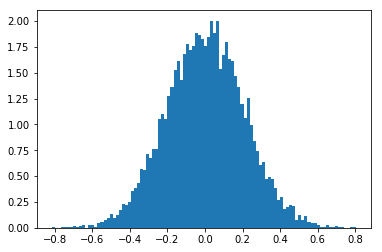

In [181]:
plt.hist(y_sampler.condition_sample().cpu().numpy().mean(axis=1), bins=100, density=True, label='true');

In [82]:
y_gen = torch.ones([10000, 1]) * 0
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1]))

y_gen = []
for i in range(1000):
    noise = torch.Tensor(sample_noise(10000, NOISE_DIM)).to(device)
    y_gen.append(generator(noise, torch.cat([mu.to(device), x_r.to(device)], dim=1)).detach().cpu().mean().item())

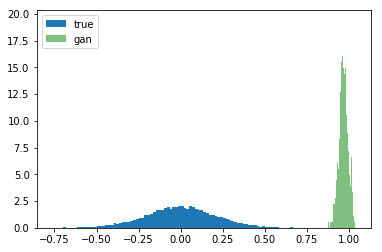

In [83]:
plt.hist(y_sampler.condition_sample().mean(dim=1).cpu().numpy(), bins=100, density=True, label='true');
plt.hist(y_gen,
         bins=100, color='g', density=True, alpha=0.5, label='gan');
plt.legend()

In [141]:
mu = torch.tensor([10.,10.]).reshape(1, -1).repeat(1000, 1)


In [142]:
y_true = []
y_gen = []
for i in range(5000):
    x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1]))
    y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
    y_true.append(y_sampler.condition_sample().mean().item())
    noise = torch.Tensor(sample_noise(1000, NOISE_DIM)).to(device)
    y_gen.append(generator(noise, torch.cat([mu.to(device), x_r.to(device)], dim=1)).mean().item())
# plt.hist(y_sampler.condition_sample().mean(dim=1).cpu().numpy(), bins=100, density=True, label='true');
# plt.hist(generator(fixed_noise, torch.cat([mu.to(device), x_r.to(device)], dim=1)).detach().cpu().numpy(),
#          bins=100, color='g', density=True, alpha=0.5, label='gan');
# plt.legend()

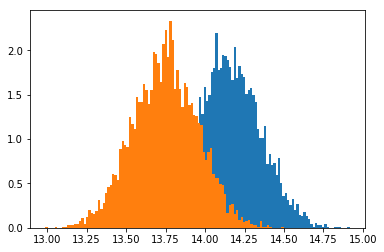

In [143]:
plt.hist(y_true, bins=100, density=True, label='true');
plt.hist(y_gen, bins=100, density=True, label='true');

In [203]:
%%time
my_cmap = plt.cm.jet
my_cmap.set_under('white')
mu_range = (-10,10)
mu = dist.Uniform(*mu_range).sample([5000, 2]).to(device)

y = np.zeros([len(mu), 1])

for i in range(len(mu)):
    #y_mean = 0
    #for j in range(10):
    noise = torch.Tensor(sample_noise(1000, NOISE_DIM)).to(device)
    mu_r = mu[i, :].reshape(1,-1).repeat(1000, 1).to(device)
    x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
    y[i, 0] = generator(noise, torch.cat([mu_r,x_r],dim=1)).mean().item()
    #y[i, 0] = y_mean / 10

CPU times: user 4.77 s, sys: 40 ms, total: 4.81 s
Wall time: 4.83 s


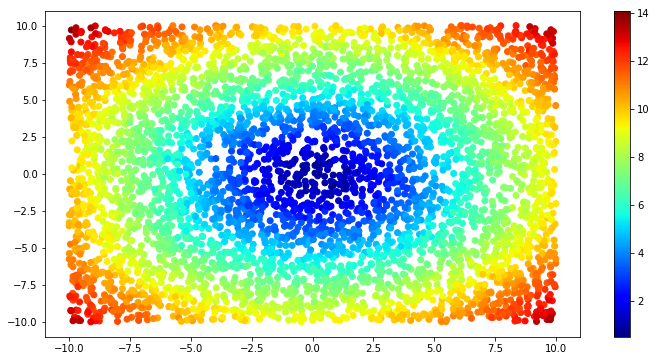

In [204]:
plt.figure(figsize=(12,6))
mu = mu.cpu().numpy()
plt.scatter(mu[:,0], mu[:, 1], c=y[:,0], cmap=my_cmap)
plt.colorbar()
plt.show()

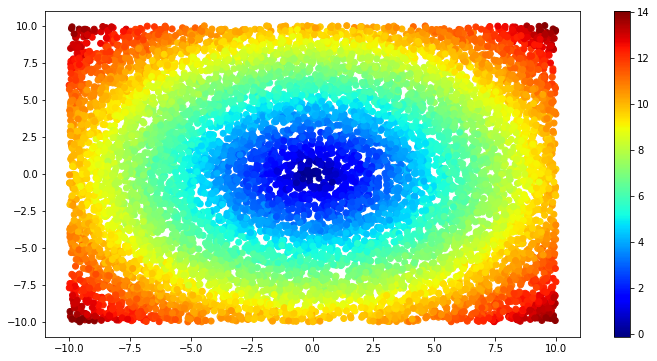

In [72]:
mu = dist.Uniform(-10,10).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})

# y = torch.ones([10000, 1000]) * 0
# for index in range(10):
#     y += y_sampler.condition_sample()
# y /= 10
y = y_sampler.condition_sample()
y_mean = y.mean(dim=1)

plt.figure(figsize=(12,6))
plt.scatter(mu[:,0], mu[:, 1], c=y_mean, cmap=my_cmap)
plt.colorbar()

CPU times: user 5.94 s, sys: 68 ms, total: 6.01 s
Wall time: 6.05 s


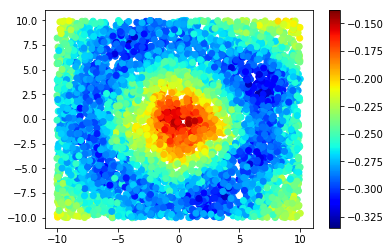

In [75]:
%%time
mu_range = (-10,10)
mu = dist.Uniform(*mu_range).sample([5000, 2]).to(device)

y = np.zeros([len(mu), 1])

rs = []
for i in range(len(mu)):
    noise = torch.Tensor(sample_noise(1000, NOISE_DIM)).to(device)
    mu_r = mu[i, :].reshape(1,-1).repeat(1000, 1).to(device)
    x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
    samples = generator(noise, torch.cat([mu_r,x_r],dim=1))
    rs.append(OptLoss.SigmoidLoss(samples, 5, 10).mean().item())

mu = mu.cpu().numpy()
plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
plt.colorbar()

torch.Size([5000, 1000])


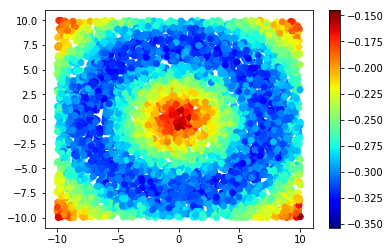

In [23]:
import numpy as np
mu = dist.Uniform(-10,10).sample([5000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
print(samples.shape)
rs = OptLoss.SigmoidLoss(samples, 5, 10)

plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
plt.colorbar()

# Test optimisation

In [50]:
from copy import deepcopy

class InputOptimisation(nn.Module):
    def __init__(self, generator_model):
        super().__init__()
        self.gen = deepcopy(generator_model)
        for param in self.gen.parameters():
            param.requires_grad = False
        self.gen.eval()
       
    def forward(self, noise, inputs):
        return self.gen(noise, inputs)
    
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')    

In [80]:
io_model = InputOptimisation(generator)

lr = 50
batch_size = 10
average_size = 1000

mu_optim = torch.tensor([-1.,-1.]).reshape(1,-1)
mu_optim = mu_optim.repeat(average_size, 1).to(device)
mu_optim.requires_grad=True

In [81]:
%%time
n_iter = 10000
losses = []
m_vals = []
for _iter in range(n_iter):
    #y_batch = torch.empty([batch_size,1], requires_grad=True)
    #for batch_i in range(batch_size):
    noise = torch.Tensor(sample_noise(average_size, NOISE_DIM)).to(device)
    x = y_sampler.x_dist.sample([average_size, 1]).to(device)
    # Do an update
    data_gen = io_model(noise, torch.cat([mu_optim, x], dim=1))
    #y_batch[batch_i, 0] = data_gen.mean()
    loss = OptLoss.SigmoidLoss(data_gen, 5, 10).mean()
    losses.append(loss.item())
    io_model.zero_grad()
    loss.backward()
    with torch.no_grad():
        mu_optim -= lr * mu_optim.grad.mean(dim=0, keepdim=True)
        mu_optim.grad.zero_()
    m_vals.append(mu_optim[0].detach().cpu().numpy())
m_vals =np.array(m_vals)    

CPU times: user 18.2 s, sys: 620 ms, total: 18.8 s
Wall time: 18.6 s


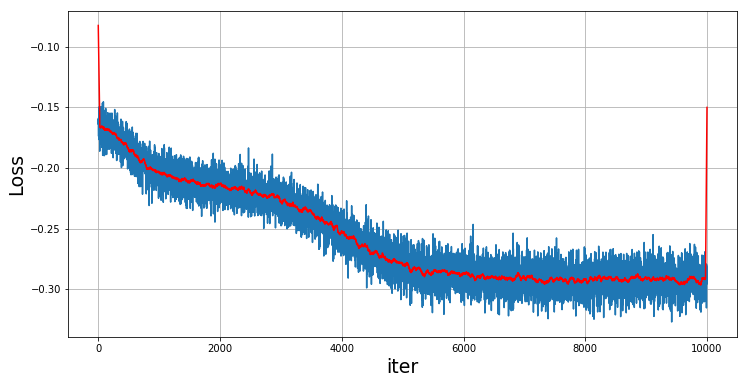

In [82]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)
plt.plot((movingaverage(losses, 50)), c='r')

Text(0.5, 0, 'iter')

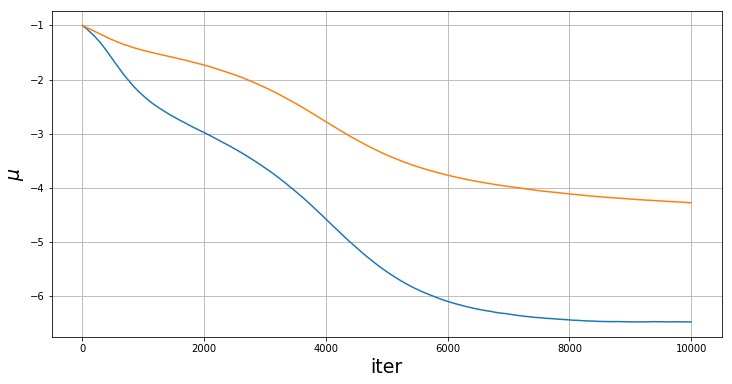

In [83]:
plt.figure(figsize=(12,6))
plt.plot(m_vals[:,0]);
plt.plot(m_vals[:,1]);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)

In [66]:
m_vals[-1]

6.745800018310547

In [85]:
def find_mu(init_mu, n_iter=100000):
    io_model = InputOptimisation(generator)
    mu_optim = torch.tensor(float(init_mu))
    mu_optim = mu_optim.repeat(sample_size).to(device)
    mu_optim.requires_grad=True
    
    #losses = []
    #m_vals = []
    for _iter in range(n_iter):    
        noise = torch.Tensor(sample_noise(sample_size, NOISE_DIM)).to(device)
        x = y_sampler.x_dist.sample([mu_optim.shape[0]]).to(device)
        # Do an update
        data_gen = io_model(noise, torch.stack([mu_optim, x], dim=1))
        loss = OptLoss.SigmoidLoss(data_gen, -5, 5)
        #losses.append(loss.item())
        io_model.zero_grad()
        loss.backward()
        with torch.no_grad():
            mu_optim -= lr * mu_optim.grad.mean()
            mu_optim.grad.zero_()
        #m_vals.append(mu_optim[0].item())
    return mu_optim[0].item()

In [90]:
opt_mu = []
for mu in np.arange(-15, 15, 1):
    opt_mu.append(find_mu(mu))

Text(0.5, 0, '$\\mu_{initial}$')

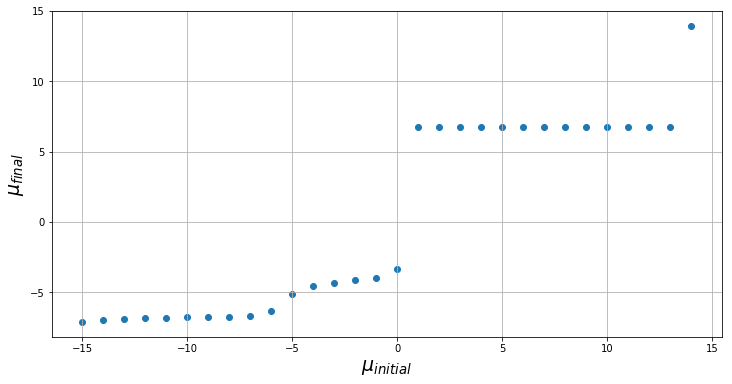

In [92]:
plt.figure(figsize=(12,6))
plt.scatter(np.arange(-15,15,1), opt_mu)
plt.grid()
plt.ylabel("$\mu_{final}$", fontsize=19)
plt.xlabel("$\mu_{initial}$", fontsize=19)